In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import time
tic=time.time()

In [2]:
dataset = sio.loadmat('anomalyData.mat')
#server data

In [3]:
dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 15:37:10 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[13.04681517, 14.74115241],
        [13.40852019, 13.7632696 ],
        [14.19591481, 15.85318113],
        [14.91470077, 16.17425987],
        [13.57669961, 14.04284944],
        [13.92240251, 13.40646894],
        [12.82213164, 14.22318782],
        [15.67636615, 15.89169137],
        [16.16287532, 16.20299807],
        [12.66645095, 14.89908374],
        [13.98454962, 12.95800822],
        [14.06146043, 14.54908874],
        [13.38988671, 15.56202142],
        [13.39350475, 15.62698794],
        [13.97900926, 13.28061494],
        [14.16791259, 14.46583829],
        [13.96176145, 14.75182421],
        [14.45899735, 15.07018563],
        [14.58476372, 15.82743424],
        [12.07427074, 13.0671109 ],
        [13.5491294 , 15.53827677],
        [13.98625042, 14.78776304],
        [14.96991942, 16.51830493],
        [14.25576597, 15.294

In [3]:
X=dataset['X']  
#training dataset

In [4]:
Xval = dataset['Xval']       #cross-validation    
yval = dataset['yval']       #the corresponding output 

In [5]:
print(X.shape)              #(rows,cols)
#the dataset contains throughput(mb/s) and latency(ms)

(307, 2)


Text(0, 0.5, 'Throughput(mb/s)')

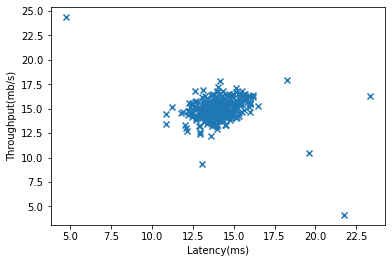

In [6]:
#plotting on the graph
plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')

In [7]:
#calculating the mean and variance
def estimateGaussian(X):
    n = np.size(X, 1)
    m = np.size(X, 0)
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    
    mu = np.reshape((1/m)*np.sum(X, 0), (1, n))
    sigma2 = np.reshape((1/m)*np.sum(np.power((X - mu),2), 0),(1, n))
    
    return mu, sigma2

mu, sigma2 = estimateGaussian(X)

In [8]:
mu, sigma2 = estimateGaussian(X)
print('mean: ',mu,' variance: ',sigma2)

mean:  [[14.11222578 14.99771051]]  variance:  [[1.83263141 1.70974533]]


In [9]:
#converting sigma2 into a covariance matrix 
def multivariateGaussian(X, mu, sigma2):
     n = np.size(sigma2, 1)
     m = np.size(sigma2, 0)
     #print(m,n)
     
     if n == 1 or m == 1:
        # print('Yes!')
         sigma2 = np.diag(sigma2[0, :])
     #print(sigma2)
     X = X - mu
     pi = math.pi
     det = np.linalg.det(sigma2)
     inv = np.linalg.inv(sigma2)
     val = np.reshape((-0.5)*np.sum(np.multiply((X@inv),X), 1),(np.size(X, 0), 1))
     #print(val.shape)
     p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)
     
     return p

In [10]:
p = multivariateGaussian(X, mu, sigma2)
print(p.shape)

(307, 1)


In [11]:
#calculating the threshold values
pval = multivariateGaussian(Xval, mu, sigma2)

In [12]:
def selectThreshHold(yval, pval):
    
    F1 = 0
    bestF1 = 0
    bestEpsilon = 0
    
    stepsize = (np.max(pval) - np.min(pval))/1000
        
    epsVec = np.arange(np.min(pval), np.max(pval), stepsize)
    noe = len(epsVec)
    
    for eps in range(noe):
        epsilon = epsVec[eps]
        pred = (pval < epsilon)
        prec, rec = 0,0
        tp,fp,fn = 0,0,0
        
        try:
            for i in range(np.size(pval,0)):
                if pred[i] == 1 and yval[i] == 1:
                    tp+=1
                elif pred[i] == 1 and yval[i] == 0:
                    fp+=1
                elif pred[i] == 0 and yval[i] == 1:
                    fn+=1
            prec = tp/(tp + fp)
            rec = tp/(tp + fn)
            F1 = 2*prec*rec/(prec + rec)
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon
        except ZeroDivisionError:
            print('Warning dividing by zero!!')          
       
    return bestF1, bestEpsilon

In [13]:
#using F1 score method to determine the best parameter
F1, epsilon = selectThreshHold(yval, pval)
print('Epsilon and F1 are:',epsilon, F1)

Warning dividing by zero!!
Epsilon and F1 are: 8.990852779269493e-05 0.8750000000000001


In [14]:
#anomalies as outliers
outl = (p < epsilon)

In [15]:
#returning the indices of the outliers to identify the faulty servers.
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

#This gives us a vector with binary entries where 1 means anomaly and 0 means normal.

In [16]:
listOfOutliers = findIndices(outl)
count_outliers = len(listOfOutliers)
print('\n\nNumber of outliers:', count_outliers)
print('\n',listOfOutliers)
#got our faulty servers



Number of outliers: 6

 [300, 301, 303, 304, 305, 306]


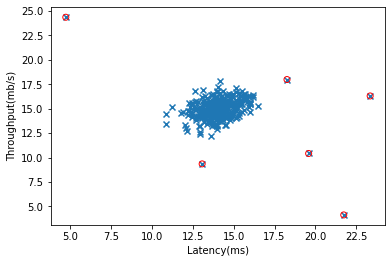

In [17]:
plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(X[listOfOutliers,0], X[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r')
plt.show()

In [18]:
#Creating the model
newDataset = sio.loadmat('anomalyDataTest.mat')

#this newDataset has 1000 examples each having 11 features.
#Xvaltest is the cross-validation set for the test samples
#yvaltest the corresponding labels.

Xtest = newDataset['X']
Xvaltest = newDataset['Xval']
yvaltest = newDataset['yval']

In [19]:
mutest, sigma2test = estimateGaussian(Xtest)
ptest = multivariateGaussian(Xtest, mutest, sigma2test)
pvaltest = multivariateGaussian(Xvaltest, mutest, sigma2test)

F1test, epsilontest = selectThreshHold(yvaltest, pvaltest)
print('\nBest epsilon and F1 are\n',epsilontest, F1test)

Warning dividing by zero!!

Best epsilon and F1 are
 1.3772288907613575e-18 0.6153846153846154


In [26]:
print(Xtest.shape)
print(Xvaltest.shape)
print(yvaltest.shape)
print(pvaltest.shape)
print(ptest.shape)

(1000, 11)
(100, 11)
(100, 1)
(100, 1)
(1000, 1)


In [21]:
outliersTest = ptest < epsilontest
listOfOl = findIndices(outliersTest)

In [22]:
print('\n\n Outliers are:\n',listOfOl)
print('\n\nNumber of outliers are: ',len(listOfOl))
toc = time.time()
print('\n\nTotal time taken: ',str(toc - tic),'sec')



 Outliers are:
 [9, 20, 21, 30, 39, 56, 62, 63, 69, 70, 77, 79, 86, 103, 130, 147, 154, 166, 175, 176, 198, 209, 212, 218, 222, 227, 229, 233, 244, 262, 266, 271, 276, 284, 285, 288, 289, 290, 297, 303, 307, 308, 320, 324, 338, 341, 342, 344, 350, 351, 353, 365, 369, 371, 378, 398, 407, 420, 421, 424, 429, 438, 452, 455, 456, 462, 478, 497, 518, 527, 530, 539, 541, 551, 574, 583, 587, 602, 613, 614, 628, 648, 674, 678, 682, 685, 700, 702, 705, 713, 721, 741, 750, 757, 758, 787, 831, 834, 836, 839, 846, 870, 885, 887, 890, 901, 911, 930, 939, 940, 943, 951, 952, 970, 975, 992, 996]


Number of outliers are:  117


Total time taken:  27.056823253631592 sec
